# K-means Clustering for Anomaly Detection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Introducing K-means

K-means clustering is a simple and useful unsupervised learning algorithm. The goal of K-means clustering is to group similar data points into a set number (K) of groups. The algorithms does this by identifying 'centroids', which are the centers of clusters, and then allocating data points to the nearest cluster.

Let's try a simple example. First we should generate some clustered data. You could imagine these clusters are different stages in the normal operation of a machine.

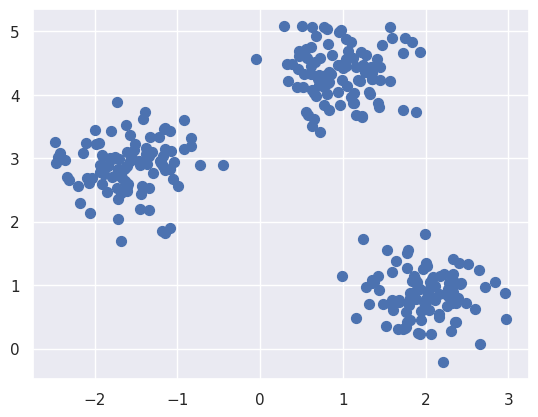

In [2]:
from sklearn.datasets import make_blobs
num_centers = 3
X_train, y_train_true = make_blobs(n_samples=300, centers=num_centers,
                                   cluster_std=0.40, random_state=0)
plt.scatter(X_train[:, 0], X_train[:, 1], s=50);

In this example it's pretty easy to visual distinguish the clusters.

Now lets use [SKLearn's KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm to fit to the data. This does a lot of the work for us, but if you would like to learn more about the underlying process check out the [wikipedia page](https://en.wikipedia.org/wiki/K-means_clustering#Algorithms)

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_centers) #we select three clusters
kmeans.fit(X_train) #we fit the centroids to the data
y_kmeans = kmeans.predict(X_train) #we determine the closest centroid for each datapoint

Now let's visualize the results. Each datapoint is color-coded according to the centroid they correspond to, and the centroids themselves are shown as black circles.

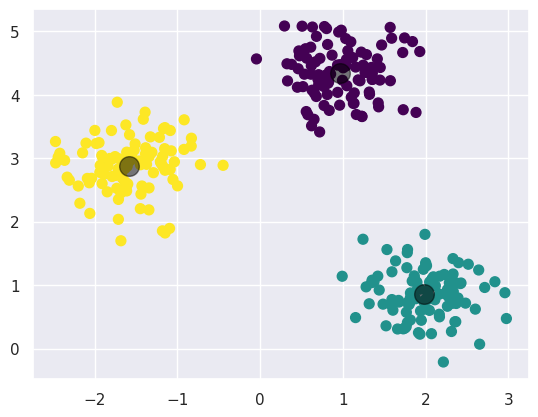

In [4]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Looks like K-means does a great job in this simple example! Now let's explore how we can use this for anomaly detection.

Below are new cluster that weren't part of our training data. We will pretend all of these are anomalies for the sake of a simple example.

One of these clusters is completely different from the data we've seen before and another is only slightly different. We can easily visually separate one of the clusters, but the other one overlaps slightly with one of our training clusters. Given the low dimensionality of the data, it's reasonable that some new data is impossible to distinguish from the training data.

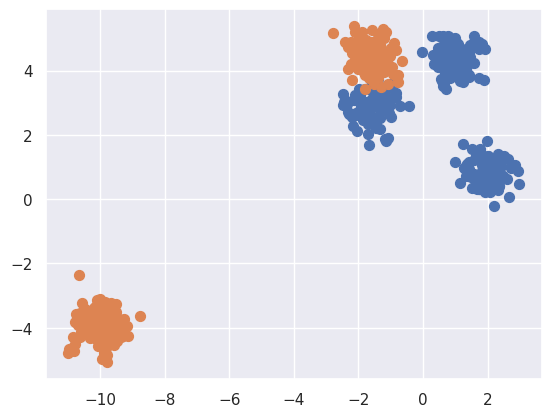

In [5]:
X_anomaly, y_anomaly_true = make_blobs(n_samples=300, centers=2,
                       cluster_std=0.40, random_state=1)
plt.scatter(X_train[:, 0], X_train[:, 1], s=50);
plt.scatter(X_anomaly[:,0], X_anomaly[:,1], s=50);

First we will calculate the distances from each datapoint to it's closest cluster center and then we calculate the 99 percentile distance for each center that was observed in the training data. We use the 99 percentile distance here since our training data could have some outliers.

These distances will act as a bounday, beyond which we will classify datapoints as anomalies. The percentile can be adjusted to be more or less sensitive depending on the application and the training data.

In [6]:
percentile_treshold = 99

train_distances = kmeans.transform(X_train)

center_distances = {key: [] for key in range(num_centers)}
for i in range(len(y_kmeans)):
  min_distance = train_distances[i][y_kmeans[i]]
  center_distances[y_kmeans[i]].append(min_distance)

center_99percentile_distance = {key: np.percentile(center_distances[key], \
                                                   percentile_treshold)   \
                                for key in center_distances.keys()}

print(center_99percentile_distance)



{0: np.float64(1.0315363528478958), 1: np.float64(1.0917976541677417), 2: np.float64(1.1415867080723232)}


Now let's plot those normal/abnomal boundaries on our training data to see how well they encompass our training data. We will also plot in yellow the points in our training data that are being classified as abnormal.

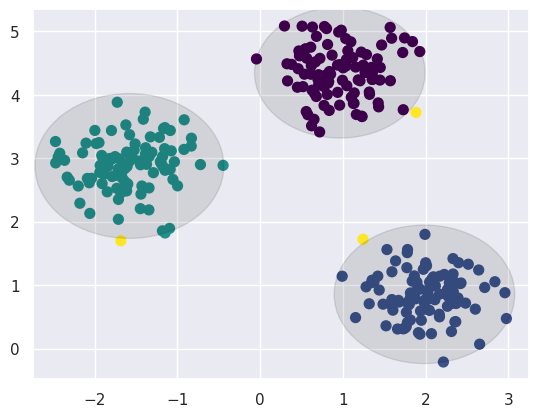

In [7]:
fig, ax = plt.subplots()

colors = []
for i in range(len(X_train)):
  min_distance = train_distances[i][y_kmeans[i]]
  if (min_distance > center_99percentile_distance[y_kmeans[i]]):
    colors.append(4)
  else:
    colors.append(y_kmeans[i])


ax.scatter(X_train[:, 0], X_train[:, 1], c=colors, s=50, cmap='viridis')

for i in range(len(centers)):
  circle = plt.Circle((centers[i][0], centers[i][1]),center_99percentile_distance[i], color='black', alpha=0.1);
  ax.add_artist(circle)

Now let's add in the abnormal test data to see how it's classified.

Normal datapoints misclassified as abnormal:  3
Abnormal datapoints misclassified as normal:  17


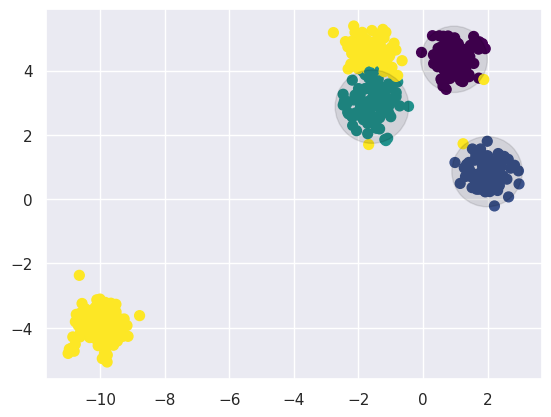

In [8]:
fig, ax = plt.subplots()

anomaly_distances = kmeans.transform(X_anomaly)
y_anomaly = kmeans.predict(X_anomaly)

#combine all the data
combined_distances = [*train_distances, *anomaly_distances]
combined_y = [*y_kmeans, *y_anomaly]
all_data = np.array([*X_train, *X_anomaly])

false_neg=0
false_pos=0

colors = []
for i in range(len(all_data)):
  min_distance = combined_distances[i][combined_y[i]]
  if (min_distance > center_99percentile_distance[combined_y[i]]):
    colors.append(4)
    if (i<300): #training data is the first 300 elements in the combined list
      false_pos+=1
  else:
    colors.append(combined_y[i])
    if (i>=300):
      false_neg+=1

ax.scatter(all_data[:, 0], all_data[:, 1], c=colors, s=50, cmap='viridis')

for i in range(len(centers)):
  circle = plt.Circle((centers[i][0], centers[i][1]),center_99percentile_distance[i], color='black', alpha=0.1);
  ax.add_artist(circle)

print('Normal datapoints misclassified as abnormal: ', false_pos)
print('Abnormal datapoints misclassified as normal: ', false_neg)

Our simple model did a pretty good job!

Now we have a way to classify abnormal data in a simple two dimension space. You can adjust the `percentile_treshold` variable to see how that impacts the number of false positives and false negatives.

Now let's see how well this applies to data with more dimensions.

##K-means on Digits



First we load in our dataset of **64** pixel images of numerical digits (think MNIST in 8x8 pixel images), **a much higher dimmension** than our 2-D problem we were dealing with earlier.

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()

normal_data = []
abnormal_data = []

normal_label = []
abnormal_label = []

num_clusters = 8

#separate our data arbitrarily into normal (2-9) and abnormal (0-1)
for i in range(len(digits.target)):
  if digits.target[i]<10-num_clusters:
    abnormal_data.append(digits.data[i])
    abnormal_label.append(digits.target[i])
  else:
    normal_data.append(digits.data[i])
    normal_label.append(digits.target[i])

Next we find our cluster centers

In [10]:
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(normal_data)

kmeans.cluster_centers_.shape

(8, 64)

Next let's visualize the centers that K-means found for each cluster. We see that K-means is able to find clusters whose centers are recognizable digits. A bit blury, but still recognizable to the human eye!

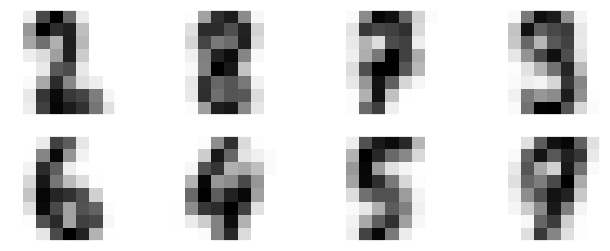

In [11]:
fig, ax = plt.subplots(2, int(num_clusters/2), figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(num_clusters, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Now let's find the 99 percentile boundary for these clusters as we did in the previous example.

In [12]:
percentile_treshold =99
normal_y = kmeans.predict(normal_data)
normal_distances = kmeans.transform(normal_data)
center_distances = {key: [] for key in range(num_clusters)}
for i in range(len(normal_y)):
  min_distance = normal_distances[i][normal_y[i]]
  center_distances[normal_y[i]].append(min_distance)

center_99percentile_distance = {key: np.percentile(center_distances[key], \
                                                   percentile_treshold)   \
                                for key in center_distances.keys()}

print(center_99percentile_distance)

{0: np.float64(34.48933560376999), 1: np.float64(35.816450545813716), 2: np.float64(36.4902271228136), 3: np.float64(36.0212464878489), 4: np.float64(34.981849080963606), 5: np.float64(37.75478889098977), 6: np.float64(35.99209658315131), 7: np.float64(38.54286836255332)}


Now lets get the distance to each centroid for our anomalous data and combine it with our normal data. Then we can classify everything as either normal or abnormal based on the distances we calculated previously.

In [13]:
abnormal_y = kmeans.predict(abnormal_data)
abnormal_distances = kmeans.transform(abnormal_data)

#combine all the data
combined_distances = [*normal_distances, *abnormal_distances]
combined_y = [*normal_y, *abnormal_y]
normal_data_length = len(normal_data)
all_data = np.array([*normal_data, *abnormal_data])

false_neg=0
false_pos=0

for i in range(len(all_data)):
  min_distance = combined_distances[i][combined_y[i]]
  if (min_distance > center_99percentile_distance[combined_y[i]]):
    if (i<normal_data_length): #training data is first
      false_pos+=1
  else:
    if (i>=normal_data_length):
      false_neg+=1

print('Normal datapoints misclassified as abnormal: ', false_pos)
print('Abnormal datapoints misclassified as normal: ', false_neg)

Normal datapoints misclassified as abnormal:  18
Abnormal datapoints misclassified as normal:  210


The results are ok but not ideal. We can try adjusting the `percentile_treshold` variable to get better results. However, generally, K-means doesn't scale well with increased dimensionality. This example is still very low dimensional compared to many real world use cases and it still has a significant impact on our accuracy. This relationship is called the [***Curse of Dimensionality***](https://en.wikipedia.org/wiki/Curse_of_dimensionality) which plauges many conventional machine learning algorithms.

Next we will explore how to improve our K-means results with some pre-processing.

##Dimensionality Reduction

To combat the ***Curse of Dimensionality*** we can try projecting our data into a low dimensional space.

We can use the t-distributed stochastic neighbor embedding ([t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)) algorithm, to pre-process the data before feeding it into K-means. t-SNE is used to visualize high dimensional data and we can use it to reduce the dimensionality of our input data which will hopefully lead to better results!

First we will run TSNE on all of our data (normal and abnormal) and later split it into our train (normal) and test (abnormal) data. This is becasue t-SNE is a transductive learner and is not intended to transform data beyond what it is trained on. There are some recent [implementations](https://github.com/kylemcdonald/Parametric-t-SNE) of a [parametric t-sne algorithm](https://lvdmaaten.github.io/publications/papers/AISTATS_2009.pdf) that can acomplish this but they are not included in sklearn.

In [14]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)
print(digits_proj.shape)

(1797, 2)


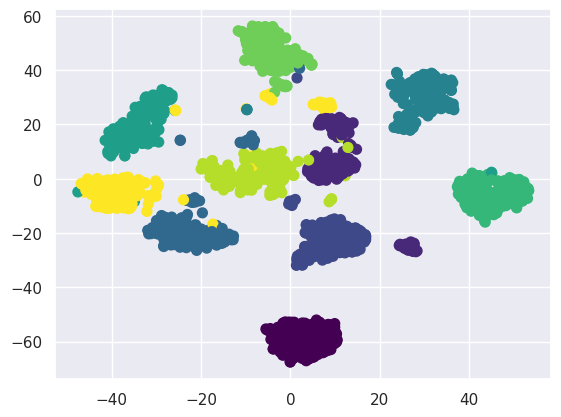

In [15]:
#Visualize our new data
fig, ax = plt.subplots()
ax.scatter(digits_proj[:, 0], digits_proj[:, 1],c=digits.target, s=50, cmap='viridis')

Now we have nicely separated two dimension data (down from our 64 pixel images)! This looks a lot more like the clusters in the first example

Next, we separate the data into normal and abnormal just like the previous example.

In [16]:
normal_data = []
abnormal_data = []

normal_label = []
abnormal_label = []

num_clusters = 8

#separate our data arbitrarily into normal (2-9) and abnormal (0-1)
for i in range(len(digits.target)):
  if digits.target[i]<10-num_clusters:
    abnormal_data.append(digits_proj[i])
    abnormal_label.append(digits.target[i])
  else:
    normal_data.append(digits_proj[i])
    normal_label.append(digits.target[i])

Now run K-means and calculate our percentile threshold.

In [17]:
# Compute the clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(normal_data)

#calculate the percentile bounday
percentile_treshold =99
normal_y = kmeans.predict(normal_data)
normal_distances = kmeans.transform(normal_data)
center_distances = {key: [] for key in range(num_clusters)}
for i in range(len(normal_y)):
  min_distance = normal_distances[i][normal_y[i]]
  center_distances[normal_y[i]].append(min_distance)

center_99percentile_distance = {key: np.percentile(center_distances[key], \
                                                   percentile_treshold)   \
                                for key in center_distances.keys()}

print(center_99percentile_distance)



{0: np.float64(15.153907548135587), 1: np.float64(13.219116504340612), 2: np.float64(20.65376465532755), 3: np.float64(11.629194253574097), 4: np.float64(9.840694958170731), 5: np.float64(20.490800710610284), 6: np.float64(9.78642500254149), 7: np.float64(15.17746280311825)}


Finally we calculate the distances of our abnormal data to our cluster centers. Then count the number of false negatives and false positives and plot all the data.

Normal datapoints misclassified as abnormal:  17
Abnormal datapoints misclassified as normal:  44


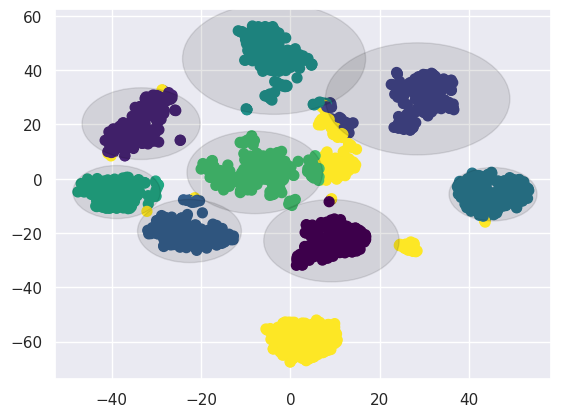

In [18]:
abnormal_y = kmeans.predict(abnormal_data)
abnormal_distances = kmeans.transform(abnormal_data)

#combine all the data
combined_distances = [*normal_distances, *abnormal_distances]
combined_y = [*normal_y, *abnormal_y]
normal_data_length = len(normal_data)
all_data = np.array([*normal_data, *abnormal_data])

false_neg=0
false_pos=0
colors = []
for i in range(len(all_data)):
  min_distance = combined_distances[i][combined_y[i]]
  if (min_distance > center_99percentile_distance[combined_y[i]]):
    colors.append(10)
    if (i<normal_data_length): #training data is first in combined set
      false_pos+=1
  else:
    colors.append(combined_y[i])
    if (i>=normal_data_length):
      false_neg+=1

fig, ax = plt.subplots()
ax.scatter(all_data[:, 0], all_data[:, 1], c=colors, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
for i in range(len(centers)):
  circle = plt.Circle((centers[i][0], centers[i][1]),center_99percentile_distance[i], color='black', alpha=0.1);
  ax.add_artist(circle)

print('Normal datapoints misclassified as abnormal: ', false_pos)
print('Abnormal datapoints misclassified as normal: ', false_neg)

**Great results!!** We've drastically reduced the number of abnormal points being misclassified as normal!

Unfortunately, while dimensionality reduction can be a power tool, it's not always a viable option. Algorithms like t-SNE can take a long time to run and won't always produce useful results.

In the next section you will learn about a neural network approach to anomaly detection which can achieve high accuracy on high dimensional data.

## Additional Readings
If you would like to learn about using reconstruction with K-means for anomaly detection check out: http://amid.fish/anomaly-detection-with-k-means-clustering